In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataset 

In [25]:
data = pd.read_csv('Desktop\\crime.csv', encoding = 'latin')

In [26]:
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


## Data cleaning


In [27]:
# null values
data.isna().sum()

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1765
REPORTING_AREA              0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
Location                    0
dtype: int64

In [28]:
# We will not delete missing observations for further analysis we will not need STREET column. 
# In terms of other variables we might loose some information when deleting NA's in Latitude and Longitude 

In [29]:
# null values in SHOOTING column mean that there was no shooting, we can replace NA with 0 and 'Y' with 1
data['SHOOTING'] = [1 if i=='Y' else 0 for i in data['SHOOTING']]

In [30]:
# how many districts do we have in boston?
data.DISTRICT.sort_values().unique()

array(['A1', 'A15', 'A7', 'B2', 'B3', 'C11', 'C6', 'D14', 'D4', 'E13',
       'E18', 'E5', nan], dtype=object)

In [31]:
# Let us replace the codes of districts with actual district names

data['district_name'] = data.DISTRICT

data.district_name.replace({'A1' : 'Downtown',
'A1': 'Downtown',
'A15': 'Charlestown',
'A7': 'East Boston',
'B2': 'Roxbury',
'B3': 'Mattapan',
'C6': 'South Boston',
'C11': 'Dorchester',
'D4': 'South End',
'D14': 'Brighton',
'E5': 'West Roxbury',
'E13': 'Jamaica Plain',               
'E18':'Hyde Park'}, inplace=True)

# Duplicates in the dataset

In [32]:
# We have 23 duplicated observations
data.duplicated().sum()

23

In [47]:
# what are those duplicates?
data[data.duplicated()].sort_values(by = 'INCIDENT_NUMBER').head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,district_name
319059,I090321958-00,3125,Warrant Arrests,WARRANT ARREST,C11,355,0,2016-02-01 01:43:00,2016,2,Monday,1,Part Three,GENEVA AVE,NaN,NaN,"(0.00000000, 0.00000000)",Dorchester
319051,I110177502-00,3125,Warrant Arrests,WARRANT ARREST,B2,318,0,2015-10-02 21:00:00,2015,10,Friday,21,Part Three,HOMESTEAD ST,42.311277,-71.089093,"(42.31127726, -71.08909334)",Roxbury
319023,I120470733-00,724,Auto Theft,AUTO THEFT,C6,205,0,2016-09-23 19:15:00,2016,9,Friday,19,Part One,A ST,42.346953,-71.051127,"(42.34695268, -71.05112684)",South Boston
319009,I130041200-00,3125,Warrant Arrests,WARRANT ARREST,B3,428,0,2015-12-07 11:38:00,2015,12,Monday,11,Part Three,DIXWELL ST,42.314334,-71.097914,"(42.31433402, -71.09791405)",Mattapan
318990,I130202615-00,3125,Warrant Arrests,WARRANT ARREST,B2,587,0,2015-08-03 17:23:00,2015,8,Monday,17,Part Three,BURNEY ST,42.331496,-71.099791,"(42.33149596, -71.09979111)",Roxbury


In [34]:
# we will not delete those duplicates, the reason for their existence might be:
# - few people involved in one crime
# - one  or more people commiting few crimes at a moment

# 1) Most dangerous day of week. Shooting and no shooting crimes.

In [35]:
data.groupby('DAY_OF_WEEK')['SHOOTING'].count()

DAY_OF_WEEK
Friday       48495
Monday       45679
Saturday     44818
Sunday       40313
Thursday     46656
Tuesday      46383
Wednesday    46729
Name: SHOOTING, dtype: int64

In [36]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = data['DAY_OF_WEEK'].map(mapping)

In [37]:
data.groupby('DAY_OF_WEEK')['SHOOTING'].sum()

DAY_OF_WEEK
Friday       143
Monday       114
Saturday     228
Sunday       155
Thursday     131
Tuesday      114
Wednesday    134
Name: SHOOTING, dtype: int64

In [38]:
data = data.iloc[key.argsort()]

2016
{'Monday': 26, 'Tuesday': 40, 'Wednesday': 21, 'Thursday': 44, 'Friday': 40, 'Saturday': 66, 'Sunday': 42}


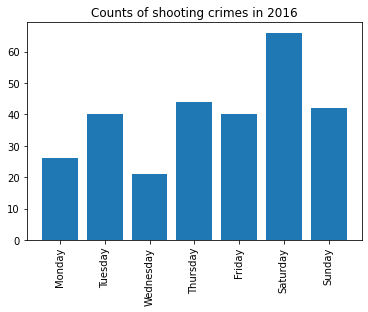

2017
{'Monday': 37, 'Tuesday': 45, 'Wednesday': 49, 'Thursday': 39, 'Friday': 54, 'Saturday': 73, 'Sunday': 73}


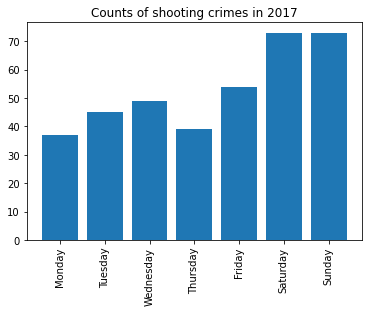

2018
{'Monday': 27, 'Tuesday': 18, 'Wednesday': 32, 'Thursday': 18, 'Friday': 28, 'Saturday': 41, 'Sunday': 21}


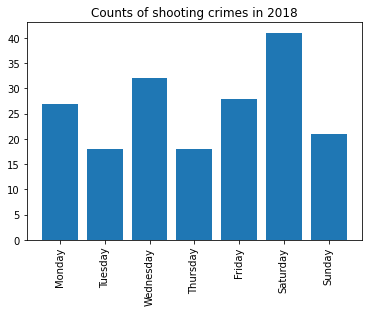

2015
{'Monday': 24, 'Tuesday': 11, 'Wednesday': 32, 'Thursday': 30, 'Friday': 21, 'Saturday': 48, 'Sunday': 19}


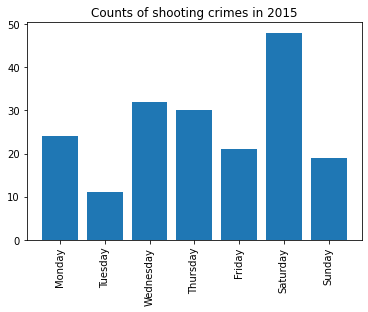

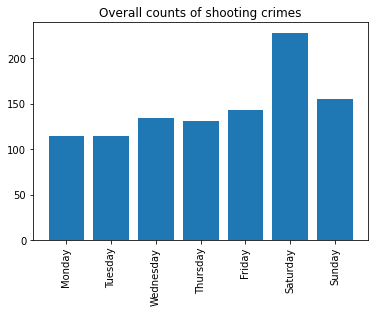

In [137]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}

for year in set(data.YEAR):
    week_counter = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
    print(year)
    df = data[data['YEAR']==year].groupby('DAY_OF_WEEK')['SHOOTING'].sum().reset_index()
    df.columns = ['DAY_OF_WEEK', 'VALUE']
    for day in week_counter.keys():
        week_counter[day] = df[df.DAY_OF_WEEK == day]['VALUE'].values[0]
    print(week_counter)
    plt.bar(week_counter.keys(), week_counter.values())
    plt.title(f'Counts of shooting crimes in {year}')
    plt.xticks(ticks=range(len(week_counter.keys())), labels=week_counter.keys(), rotation=90)
    plt.show()
week_counter = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
df = data.groupby('DAY_OF_WEEK')['SHOOTING'].sum().reset_index()
df.columns = ['DAY_OF_WEEK', 'VALUE']
for day in week_counter.keys():
    week_counter[day] = df[df.DAY_OF_WEEK == day]['VALUE'].values[0]
    
plt.bar(week_counter.keys(), week_counter.values())
plt.title(f'Overall counts of shooting crimes')
plt.xticks(ticks=range(len(df)), labels=week_counter.keys(), rotation=90)
plt.show()

In [103]:
import scipy
from statsmodels.stats.weightstats import ztest

In [107]:
print(week_days=='Monday')

159536     True
135169     True
135168     True
135167     True
135166     True
          ...  
203144    False
203143    False
203142    False
203149    False
0         False
Name: DAY_OF_WEEK, Length: 319073, dtype: bool


In [146]:
# test the hypothesis that during Saturday the number of crimes with shooting is bigger than in any other days
# construct column with all weekdays of crimes
week_days = data[data.SHOOTING == 1].DAY_OF_WEEK

for day in week_counter.keys():
    for another_day in week_counter.keys():
        if day != another_day:
            day_counts = week_days == day
            another_day_counts = week_days == another_day
            z_score, pv = ztest(day_counts, another_day_counts, alternative = 'larger')
            print(f'testing {day} having more crimes than {another_day}: \n z-score:{z_score}, p-value: {pv:.3f}')
            print(day_counts.sum(), another_day_counts.sum())
            if pv < 0.05/9:
                print(f'{day} has significantly larger number of crimes than {another_day} \n')
            else:
                print('difference is not significant \n')

    

{'Monday': 114, 'Tuesday': 114, 'Wednesday': 134, 'Thursday': 131, 'Friday': 143, 'Saturday': 228, 'Sunday': 155}
testing Monday having more crimes than Tuesday: 
 z-score:0.0, p-value: 0.500
114 114
difference is not significant 

testing Monday having more crimes than Wednesday: 
 z-score:-1.355071708884565, p-value: 0.912
114 134
difference is not significant 

testing Monday having more crimes than Thursday: 
 z-score:-1.1577306383138037, p-value: 0.877
114 131
difference is not significant 

testing Monday having more crimes than Friday: 
 z-score:-1.935921362892027, p-value: 0.974
114 143
difference is not significant 

testing Monday having more crimes than Saturday: 
 z-score:-6.831065066275271, p-value: 1.000
114 228
difference is not significant 

testing Monday having more crimes than Sunday: 
 z-score:-2.6865883514090934, p-value: 0.996
114 155
difference is not significant 

testing Tuesday having more crimes than Monday: 
 z-score:0.0, p-value: 0.500
114 114
difference is

In [147]:
# We can see from the above that on saturday the number of shooting crimes committed is significantly higher
# than in any other day of week

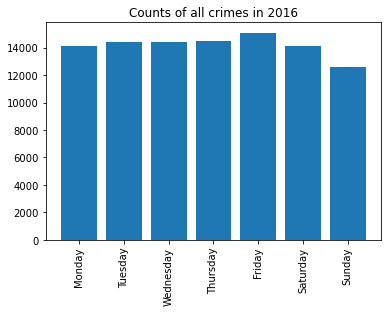

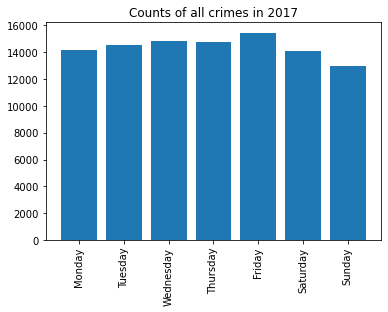

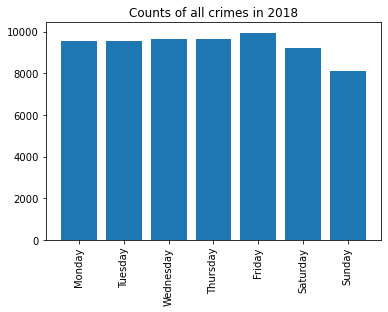

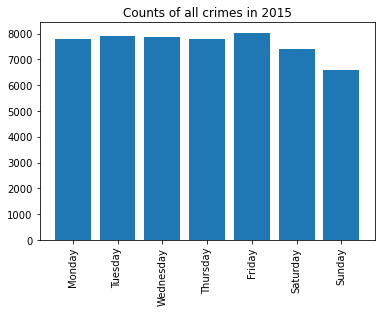

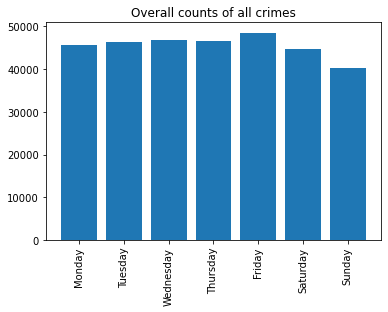

In [53]:
# crimes without shooting
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}

for year in set(data.YEAR):
    week_counter = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
    df = data[data['YEAR']==year].groupby('DAY_OF_WEEK')['OFFENSE_CODE_GROUP'].count().reset_index()
    df.columns = ['DAY_OF_WEEK', 'VALUE']
    for day in week_counter.keys():
        week_counter[day] = df[df.DAY_OF_WEEK == day]['VALUE'].values[0]
#     print(week_counter)
    plt.bar(week_counter.keys(), week_counter.values())
    plt.title(f'Counts of all crimes in {year}')
    plt.xticks(ticks=range(len(df)), labels=week_counter.keys(), rotation=90)
    plt.show()
week_counter = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
df = data.groupby('DAY_OF_WEEK')['OFFENSE_CODE_GROUP'].count().reset_index()
df.columns = ['DAY_OF_WEEK', 'VALUE']
for day in week_counter.keys():
    week_counter[day] = df[df.DAY_OF_WEEK == day]['VALUE'].values[0]
    
plt.bar(week_counter.keys(), week_counter.values())
plt.title(f'Overall counts of all crimes')
plt.xticks(ticks=range(len(df)), labels=week_counter.keys(), rotation=90)
plt.show()

In [148]:
# test the hypothesis that during Saturday the number of all crimes is bigger than in any other days
# construct column with all weekdays of crimes
week_days = data.DAY_OF_WEEK

for day in week_counter.keys():
    for another_day in week_counter.keys():
        if day != another_day:
            day_counts = week_days == day
            another_day_counts = week_days == another_day
            z_score, pv = ztest(day_counts, another_day_counts, alternative = 'larger')
            print(f'testing {day} having more crimes than {another_day}: \n z-score:{z_score}, p-value: {pv:.3f}')
            print(day_counts.sum(), another_day_counts.sum())
            if pv < 0.05/9:
                print(f'{day} has significantly larger number of crimes than {another_day} \n')
            else:
                print('difference is not significant \n')

    

{'Monday': 114, 'Tuesday': 114, 'Wednesday': 134, 'Thursday': 131, 'Friday': 143, 'Saturday': 228, 'Sunday': 155}
testing Monday having more crimes than Tuesday: 
 z-score:-2.50821185499817, p-value: 0.994
45679 46383
difference is not significant 

testing Monday having more crimes than Wednesday: 
 z-score:-3.7351367656118164, p-value: 1.000
45679 46729
difference is not significant 

testing Monday having more crimes than Thursday: 
 z-score:-3.4765918112772294, p-value: 1.000
45679 46656
difference is not significant 

testing Monday having more crimes than Friday: 
 z-score:-9.939666890229194, p-value: 1.000
45679 48495
difference is not significant 

testing Monday having more crimes than Saturday: 
 z-score:3.0895661905533203, p-value: 0.001
45679 44818
Monday has significantly larger number of crimes than Saturday 

testing Monday having more crimes than Sunday: 
 z-score:19.67807459008959, p-value: 0.000
45679 40313
Monday has significantly larger number of crimes than Sunday 

## 2) no crimes by month, day of week, hours

In [54]:
data['YEAR'].value_counts()

2017    100886
2016     99114
2018     65685
2015     53388
Name: YEAR, dtype: int64

In [56]:
# number of observations in each month
data[data['YEAR']==2017]['MONTH'].value_counts()

8     9206
7     9075
6     8985
9     8940
10    8846
5     8715
3     8179
4     8069
1     7993
11    7935
12    7535
2     7408
Name: MONTH, dtype: int64

2016


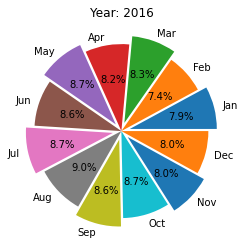

2017


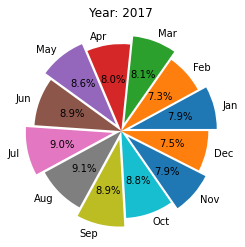

2018


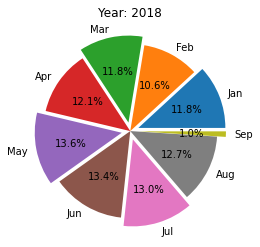

2015


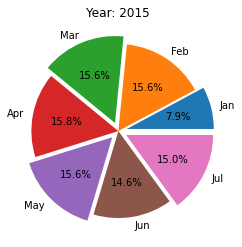

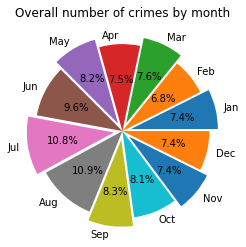

In [57]:
# Visualize the frequency of crimes committed in each month
labels = ['Jan','Feb','Mar','Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
explode = [0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0]

for year in set(data.YEAR):
    print(year)
    df = data[data['YEAR']==year].groupby('MONTH')['OFFENSE_CODE_GROUP'].count()
#     print(df)
    plt.pie(df, labels = labels[:len(df)], autopct = '%1.1f%%',explode = explode[:len(df)])
    plt.title(f'Year: {year}')
    plt.show()
df = data.groupby('MONTH')['OFFENSE_CODE_GROUP'].count()
#     print(df)
plt.pie(df, labels = labels[:len(df)], autopct = '%1.1f%%',explode = explode[:len(df)])
plt.title(f'Overall number of crimes by month')
plt.show()

In [151]:
# In Year 2015 some months were not reported, we will not take into account this year
data2 = data[data.YEAR != 2015]

2017    100886
2016     99114
2018     65685
Name: YEAR, dtype: int64

In [164]:
month_counter = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'June':0, 'Jul':0, 'Aug': 0, 'Oct':0, 'Nov':0, 'Dec':0}
df = data2.groupby('MONTH')['OFFENSE_CODE_GROUP'].count().reset_index()
df.columns = ['MONTH', 'VALUE']

for i, month in enumerate(month_counter.keys()):
    month_counter[month] = df[df.MONTH == i+1]['VALUE'].values[0]
    

In [165]:
print(month_counter)

{'Jan': 23610, 'Feb': 21653, 'Mar': 24146, 'Apr': 24086, 'May': 26199, 'June': 26377, 'Jul': 26232, 'Aug': 26481, 'Oct': 18129, 'Nov': 17429, 'Dec': 15857}


In [168]:
# Checking if any month has significanty more crimes than other

months = df.MONTH

for i1, m1 in enumerate(month_counter.keys()):
    for i2, m2 in enumerate(month_counter.keys()):
        if month != another_day:
            month_counts = months == i1+1
            another_month_counts = months == i2+1
            z_score, pv = ztest(month_counts, another_month_counts, alternative = 'larger')
            print(f'testing {m1} having more crimes than {m2}: \n z-score:{z_score}, p-value: {pv:.3f}')
            print(month_counts.sum(), another_month_counts.sum())
            if pv < 0.05/9:
                print(f'{m1} has significantly larger number of crimes than {m2} \n')
            else:
                print('difference is not significant \n')

    

testing Jan having more crimes than Jan: 
 z-score:0.0, p-value: 0.500
23610 23610
difference is not significant 

testing Jan having more crimes than Feb: 
 z-score:9.543880582072012, p-value: 0.000
23610 21653
Jan has significantly larger number of crimes than Feb 

testing Jan having more crimes than Mar: 
 z-score:-2.5500158468325784, p-value: 0.995
23610 24146
difference is not significant 

testing Jan having more crimes than Apr: 
 z-score:-2.2658726747108124, p-value: 0.988
23610 24086
difference is not significant 

testing Jan having more crimes than May: 
 z-score:-12.082980594185312, p-value: 1.000
23610 26199
difference is not significant 

testing Jan having more crimes than June: 
 z-score:-31.273054389072968, p-value: 1.000
23610 30568
difference is not significant 

testing Jan having more crimes than Jul: 
 z-score:-47.692081978266394, p-value: 1.000
23610 34556
difference is not significant 

testing Jan having more crimes than Aug: 
 z-score:-48.758803476508945, p-v

34556 30568
Jul has significantly larger number of crimes than June 

testing Jul having more crimes than Jul: 
 z-score:0.0, p-value: 0.500
34556 34556
difference is not significant 

testing Jul having more crimes than Aug: 
 z-score:-1.0737168919635023, p-value: 0.859
34556 34823
difference is not significant 

testing Jul having more crimes than Oct: 
 z-score:34.12146431476208, p-value: 0.000
34556 26543
Jul has significantly larger number of crimes than Oct 

testing Jul having more crimes than Nov: 
 z-score:37.785209671573384, p-value: 0.000
34556 25737
Jul has significantly larger number of crimes than Nov 

testing Jul having more crimes than Dec: 
 z-score:47.38397915599167, p-value: 0.000
34556 23675
Jul has significantly larger number of crimes than Dec 

testing Aug having more crimes than Jan: 
 z-score:48.758803476508945, p-value: 0.000
34823 23610
Aug has significantly larger number of crimes than Jan 

testing Aug having more crimes than Feb: 
 z-score:58.200188296432

2016


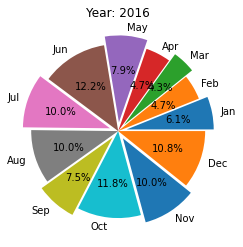

2017


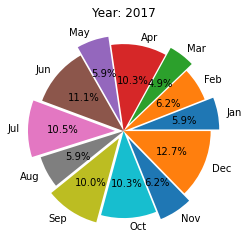

2018


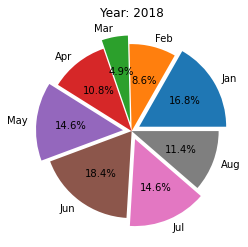

2015


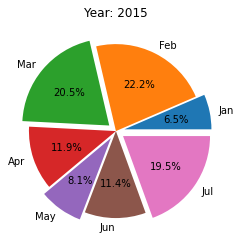

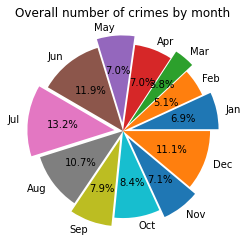

In [14]:
# By MONTH with shooting
labels = ['Jan','Feb','Mar','Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
explode = [0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0]

for year in set(data.YEAR):
    print(year)
    df = data[np.logical_and(data['YEAR']==year, data['SHOOTING']=='Y')].groupby('MONTH')['OFFENSE_CODE_GROUP'].count()
#     print(df)
    plt.pie(df, labels = labels[:len(df)], autopct = '%1.1f%%',explode = explode[:len(df)])
    plt.title(f'Year: {year}')
    plt.show()
df = data[data['SHOOTING'] =='Y'].groupby('MONTH')['OFFENSE_CODE_GROUP'].count()
#     print(df)
plt.pie(df, labels = labels[:len(df)], autopct = '%1.1f%%',explode = explode[:len(df)])
plt.title(f'Overall number of crimes by month')
plt.show()

In [173]:
data2 = data[data.SHOOTING == 1][data.YEAR != 2015]
month_counter = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'June':0, 'Jul':0, 'Aug': 0, 'Oct':0, 'Nov':0, 'Dec':0}
df = data2.groupby('MONTH')['OFFENSE_CODE_GROUP'].count().reset_index()
df.columns = ['MONTH', 'VALUE']

for i, month in enumerate(month_counter.keys()):
    month_counter[month] = df[df.MONTH == i+1]['VALUE'].values[0]
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [174]:
month_counter

{'Jan': 70,
 'Feb': 52,
 'Mar': 39,
 'Apr': 71,
 'May': 71,
 'June': 109,
 'Jul': 94,
 'Aug': 71,
 'Oct': 58,
 'Nov': 71,
 'Dec': 51}

In [175]:
# Checking if any month has significanty more shooting crimes than other

months = data2[data2.SHOOTING ==1].MONTH

for i1, m1 in enumerate(month_counter.keys()):
    for i2, m2 in enumerate(month_counter.keys()):
        if month != another_day:
            month_counts = months == i1+1
            another_month_counts = months == i2+1
            z_score, pv = ztest(month_counts, another_month_counts, alternative = 'larger')
            print(f'testing {m1} having more crimes than {m2}: \n z-score:{z_score}, p-value: {pv:.3f}')
            print(month_counts.sum(), another_month_counts.sum())
            if pv < 0.05/9:
                print(f'{m1} has significantly larger number of crimes than {m2} \n')
            else:
                print('difference is not significant \n')

    

testing Jan having more crimes than Jan: 
 z-score:0.0, p-value: 0.500
70 70
difference is not significant 

testing Jan having more crimes than Feb: 
 z-score:1.693162660838322, p-value: 0.045
70 52
difference is not significant 

testing Jan having more crimes than Mar: 
 z-score:3.0781826808872554, p-value: 0.001
70 39
Jan has significantly larger number of crimes than Mar 

testing Jan having more crimes than Apr: 
 z-score:-0.08796490383028648, p-value: 0.535
70 71
difference is not significant 

testing Jan having more crimes than May: 
 z-score:-0.08796490383028648, p-value: 0.535
70 71
difference is not significant 

testing Jan having more crimes than June: 
 z-score:-3.092224198891097, p-value: 0.999
70 109
difference is not significant 

testing Jan having more crimes than Jul: 
 z-score:-1.974742991623185, p-value: 0.976
70 94
difference is not significant 

testing Jan having more crimes than Aug: 
 z-score:-0.08796490383028648, p-value: 0.535
70 71
difference is not signi

In [176]:
# # each day of week 
# labels = ['Tue','Wed','Thu','Fri', 'Sat', 'Sun', 'Mon']
# explode = [0.1, 0, 0.1, 0, 0.1, 0,0.1]

# for year in set(data.YEAR):
#     print(year)
#     df = data[data['YEAR']==year].groupby('DAY_OF_WEEK')['OFFENSE_CODE_GROUP'].count()
#     df = df.reset_index()
#     cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#     df['DAY_OF_WEEK'] = pd.Categorical(df['DAY_OF_WEEK'], categories=cats, ordered=True)
#     df = df.sort_values('DAY_OF_WEEK')
#     plt.pie(df['OFFENSE_CODE_GROUP'], labels = df['DAY_OF_WEEK'], autopct = '%1.1f%%',explode = explode)
# #     plt.pie(df, autopct = '%1.1f%%')
    
#     plt.title(f'Year: {year}')
#     plt.show()
# #     print(f'most crimes are commited at {df[df['OFFENSE_CODE_GROUP'] == df['OFFENSE_CODE_GROUP'].max()]}')
    
# df = data.groupby('DAY_OF_WEEK')['OFFENSE_CODE_GROUP'].count()
# #     print(df)
# cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# df = df.reset_index()
# df['DAY_OF_WEEK'] = pd.Categorical(df['DAY_OF_WEEK'], categories=cats, ordered=True)
# df = df.sort_values('DAY_OF_WEEK')
# plt.pie(df['OFFENSE_CODE_GROUP'],labels = df['DAY_OF_WEEK'], autopct = '%1.1f%%',explode = explode)
# plt.title(f'Overall number of crimes by day of week')
# plt.show()

2016


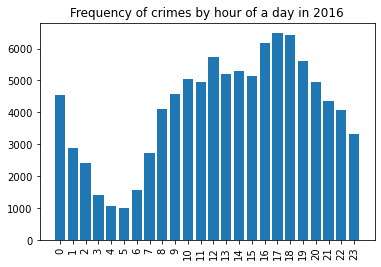

2017


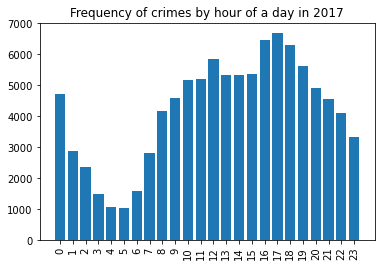

2018


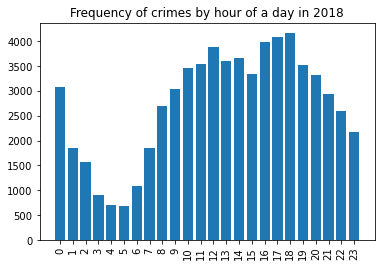

2015


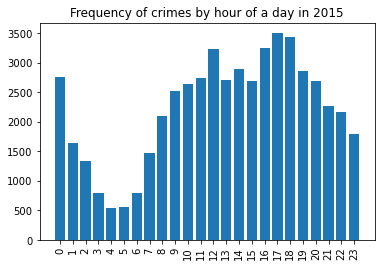

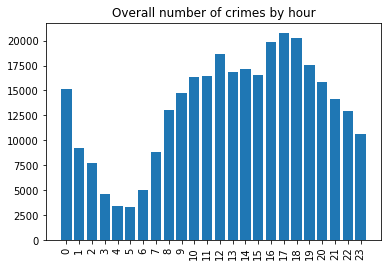

In [61]:
# frequency of crimes by hour of day
labels = [str(i) for i in range(1,25)]
explode = [0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1, 0,0.1]

for year in set(data.YEAR):
    print(year)
    df = data[data['YEAR']==year].groupby('HOUR')['OFFENSE_CODE_GROUP'].count()
#     print(df)
    df = df.reset_index()
#     print(df)
#     cats = [str(i) for i in range(1,25)]
#     df['HOUR'] = pd.Categorical(df['HOUR'], categories=cats, ordered=True)
    
    df = df.sort_values('HOUR')
#     print(df)
    plt.bar(df.HOUR, df.OFFENSE_CODE_GROUP)
    plt.title(f'Frequency of crimes by hour of a day in {year}')
    plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
    plt.show()
    
labels = [str(i) for i in range(1,25)]
explode = [0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1,0,0.1, 0,0.1]    
df = data.groupby('HOUR')['OFFENSE_CODE_GROUP'].count()
#     print(df)
plt.bar(df.index, df)
plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
plt.title(f'Overall number of crimes by hour')
plt.show()

## 3) Number of crimes by district

In [62]:
data.columns

Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location', 'district_name'],
      dtype='object')

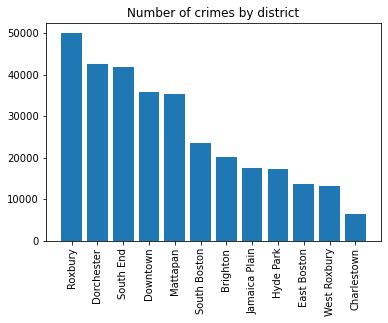

In [71]:
# no crimes by district

df = data.groupby('district_name')['OFFENSE_CODE_GROUP'].count().sort_values(ascending = False)
plt.title('Number of crimes by district')
plt.bar(df.index, height = df)
plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
plt.show()

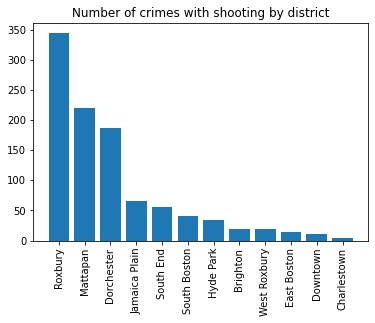

In [78]:
# no shooting

df = data[data.SHOOTING ==1].groupby('district_name')['OFFENSE_CODE_GROUP'].count().sort_values(ascending = False)
plt.title('Number of crimes with shooting by district')
plt.bar(df.index, height = df)
plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
plt.show()

YEAR: 2016


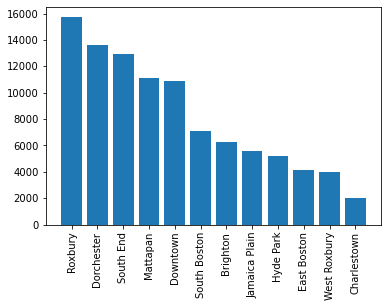

YEAR: 2017


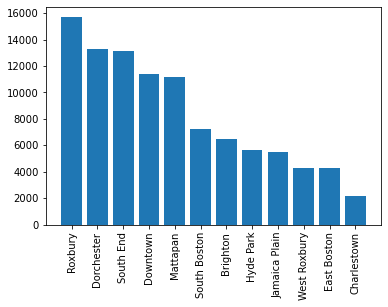

YEAR: 2018


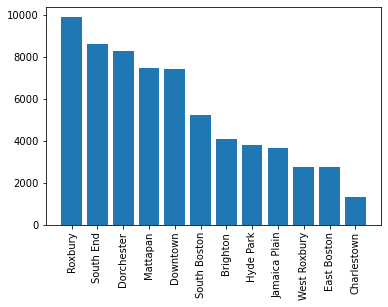

YEAR: 2015


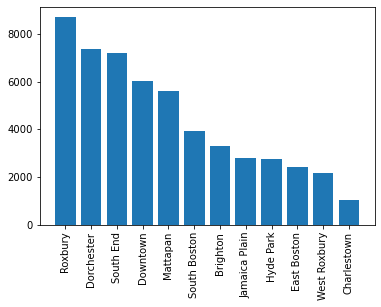

In [79]:
# by years
for i in set(data.YEAR):
    df = data[data.YEAR==i].groupby('district_name')['OFFENSE_CODE_GROUP'].count().sort_values(ascending = False)
    print(f'YEAR: {i}')
    plt.bar(df.index, height = df)
    plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
    plt.show()

YEAR: 2016


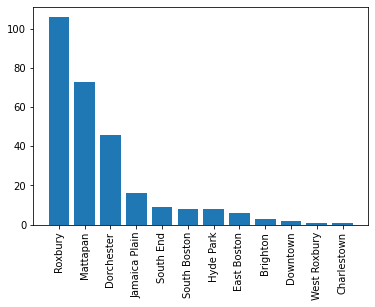

YEAR: 2017


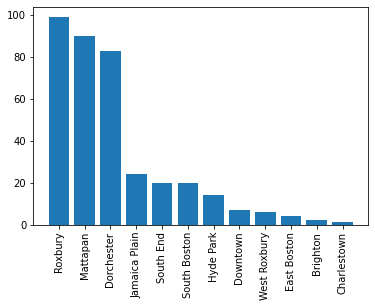

YEAR: 2018


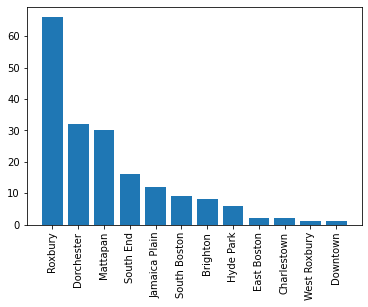

YEAR: 2015


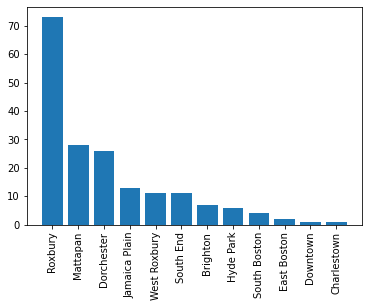

In [81]:
# no shooting over years

# by years
for i in set(data.YEAR):
    df = data[np.logical_and(data.SHOOTING ==1,data.YEAR==i)].groupby('district_name')['OFFENSE_CODE_GROUP'].count().sort_values(ascending = False)
    print(f'YEAR: {i}')
    plt.bar(df.index, height = df)
    plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
    plt.show()

YEAR: 2016


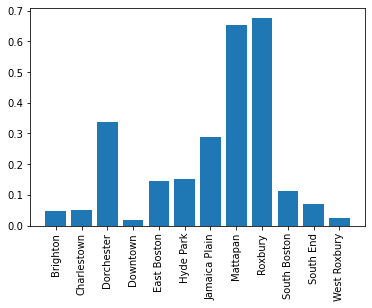

YEAR: 2017


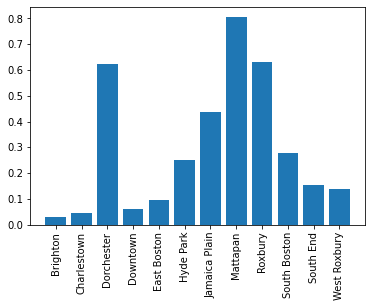

YEAR: 2018


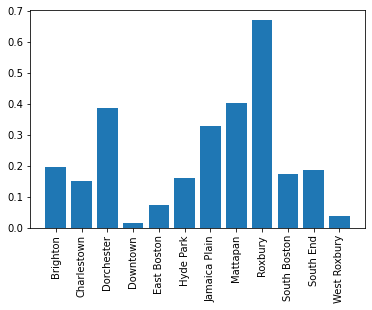

YEAR: 2015


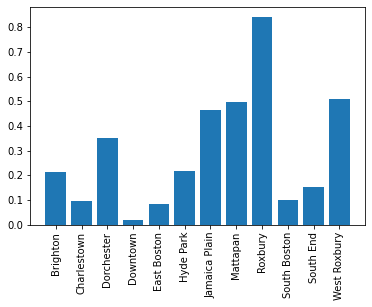

In [90]:
# proportion of shooting to crimes

for i in set(data.YEAR):
    df1 = data[data.YEAR==i].groupby('district_name')['OFFENSE_CODE_GROUP'].count().reset_index()
    df2 = data[np.logical_and(data.SHOOTING ==1,data.YEAR==i)].groupby('district_name')['OFFENSE_CODE_GROUP'].count().reset_index()
    df2.columns = ['district_name', 'OFFENSE_SHOOTING']
   
    df = pd.merge(df1, df2,on= 'district_name')
    df['Percent_shooting'] = df.OFFENSE_SHOOTING/df.OFFENSE_CODE_GROUP*100
    df = df.sort_values(by='district_name')
    print(f'YEAR: {i}')
    plt.bar(df.district_name, height = df.Percent_shooting)
    plt.xticks(ticks=range(len(df)), labels=df.district_name, rotation=90)
    plt.show()

## 2) Most common crimes

In [183]:
# most common crimes in each month
df = data.groupby(['MONTH','OFFENSE_CODE_GROUP'])['OFFENSE_DESCRIPTION'].count().sort_values(ascending=False).head()
# months = set(data.MONTH)
# for m in months:
#     df= data[data['MONTH']==m]['OFFENSE_DESCRIPTION'].value_counts().sort_values()[-1]
#     print(m, df)
df
    

MONTH  OFFENSE_CODE_GROUP             
8      Motor Vehicle Accident Response    3980
7      Motor Vehicle Accident Response    3841
6      Motor Vehicle Accident Response    3535
10     Motor Vehicle Accident Response    3092
9      Motor Vehicle Accident Response    3043
Name: OFFENSE_DESCRIPTION, dtype: int64

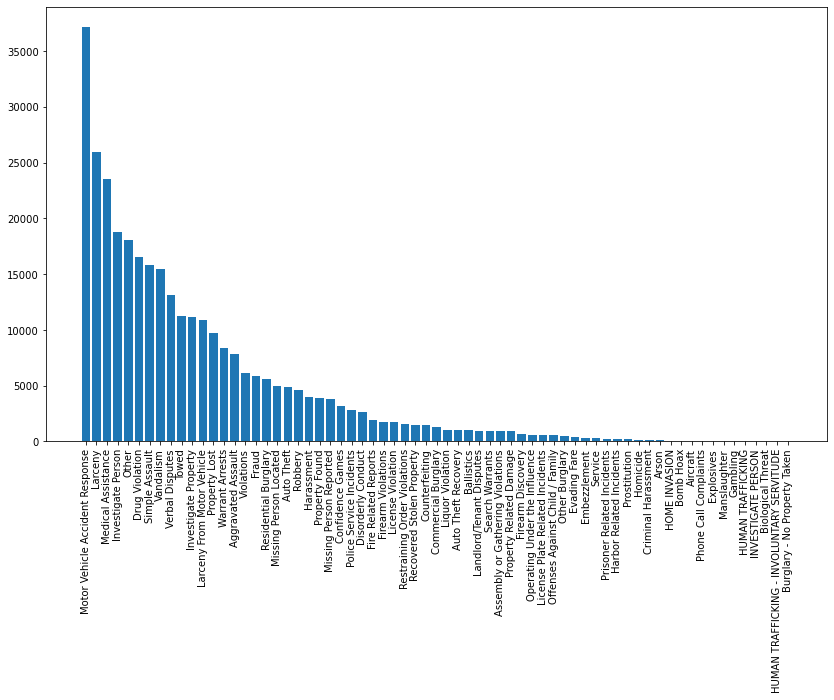

In [177]:
df = data['OFFENSE_CODE_GROUP'].value_counts()
plt.figure(figsize=(14,8))
plt.bar(df.index, height = df)
plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
plt.show()

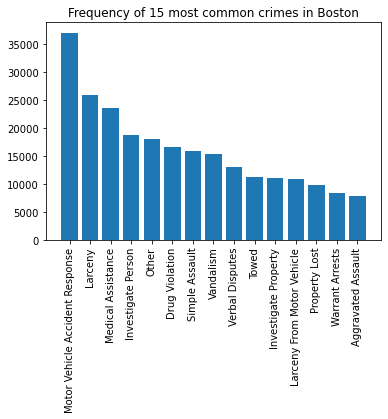

In [9]:
df = data['OFFENSE_CODE_GROUP'].value_counts().sort_values(ascending = False)[:15]
plt.bar(df.index, height = df)
plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
plt.title('Frequency of 15 most common crimes in Boston')
plt.show()

district: nan


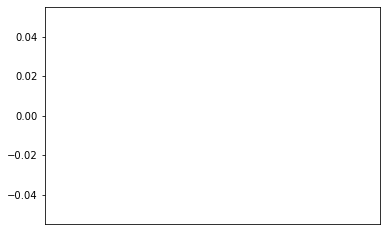

district: C6


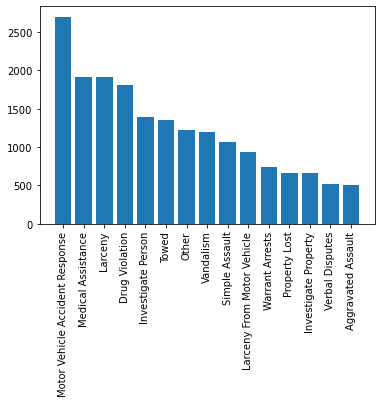

district: A1


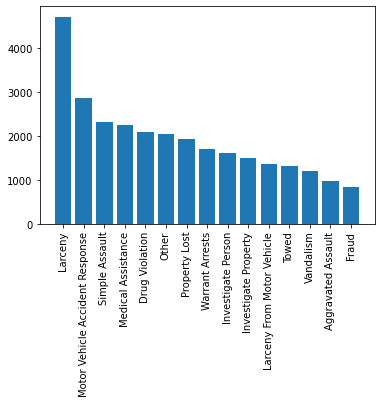

district: A7


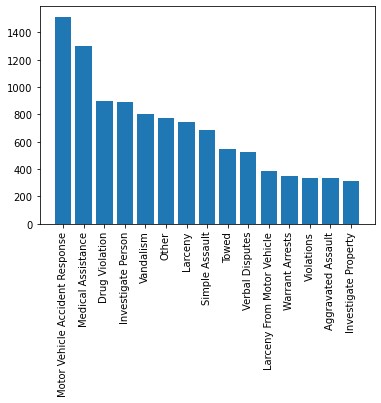

district: C11


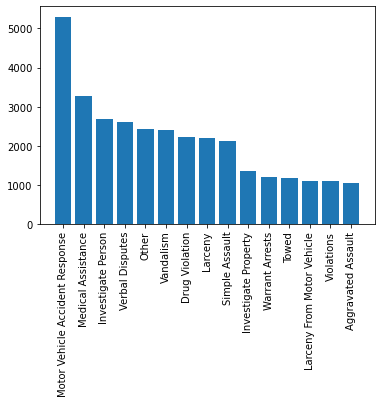

district: B3


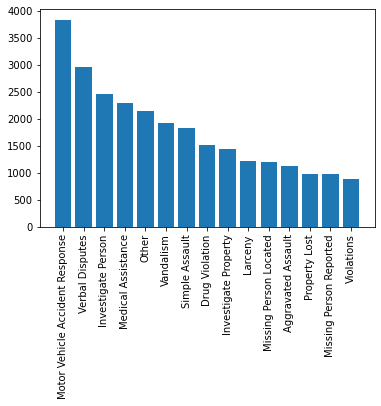

district: D4


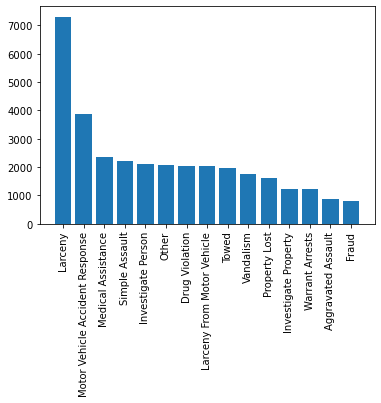

district: D14


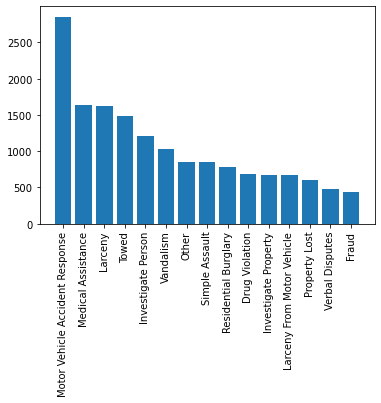

district: E5


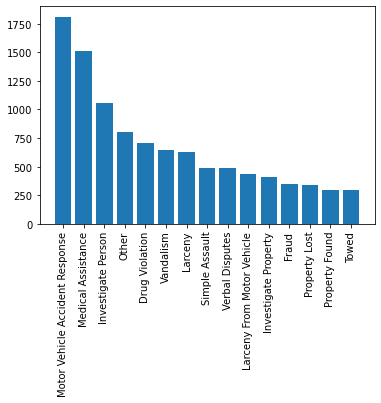

district: E18


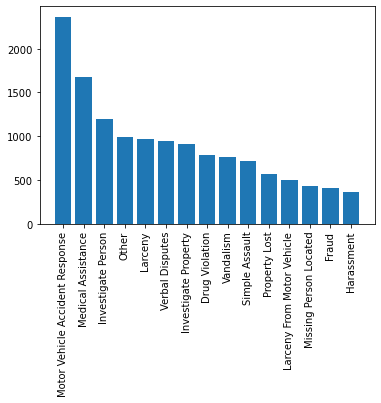

district: B2


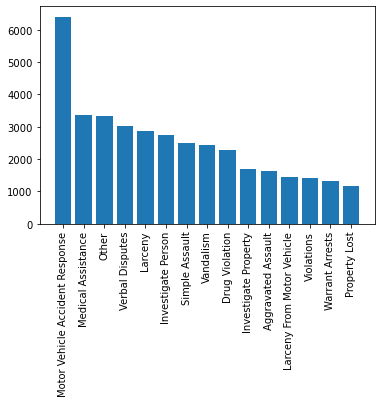

district: E13


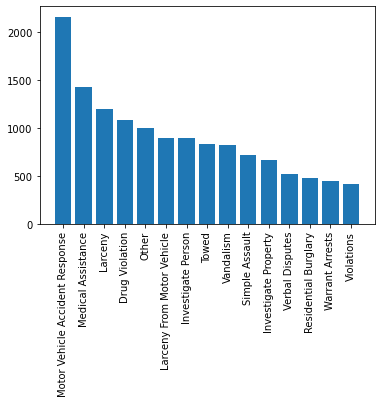

district: A15


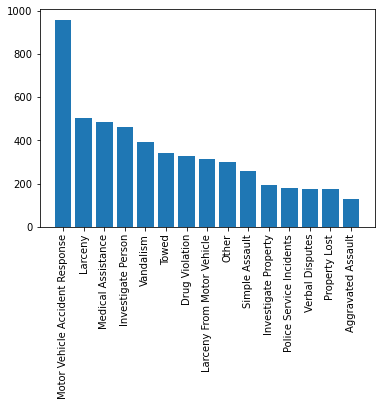

In [14]:
# Most common crimes by district
for i in set(data.DISTRICT):
    df = data[data.DISTRICT==i]['OFFENSE_CODE_GROUP'].value_counts().sort_values(ascending = False)[:15]
    print(f'district: {i}')
    plt.bar(df.index, height = df)
    plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
    plt.show()

In [10]:
# te same wykresy uwzględniając populację

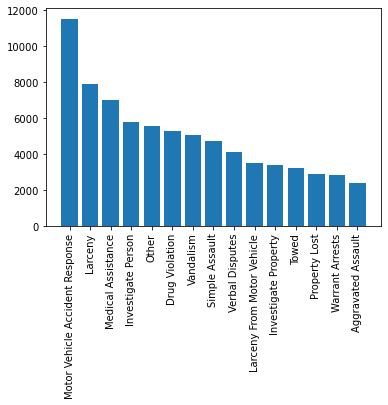

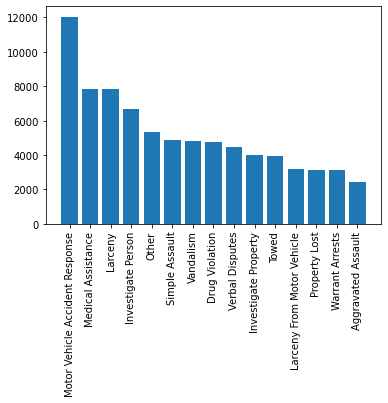

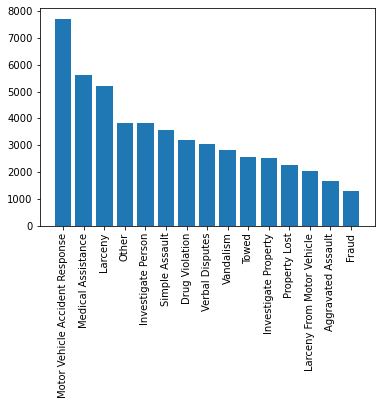

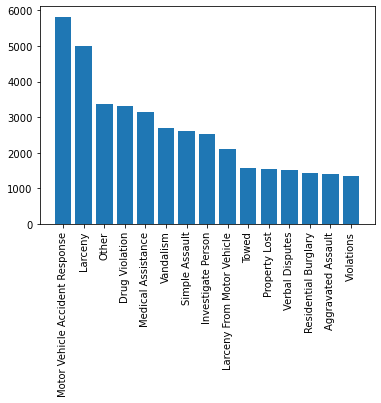

In [12]:
# same plots by year
for i in set(data.YEAR):
    df = data[data.YEAR==i]['OFFENSE_CODE_GROUP'].value_counts().sort_values(ascending = False)[:15]
    plt.bar(df.index, height = df)
    plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
    plt.show()

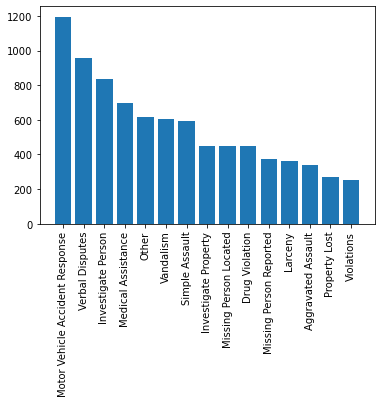

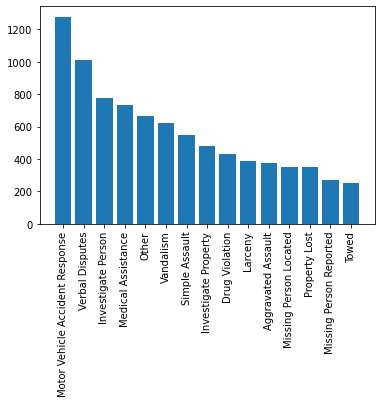

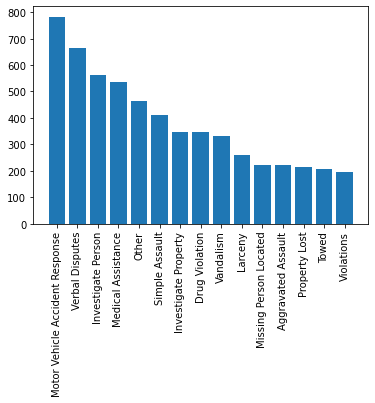

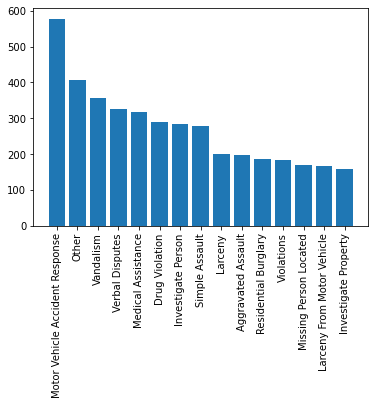

In [16]:
# closer look at district B3 (larceny anomally)
for i in set(data.YEAR):
    df = data[np.logical_and(data.YEAR==i, data.DISTRICT == 'B3')]['OFFENSE_CODE_GROUP'].value_counts().sort_values(ascending = False)[:15]
    plt.bar(df.index, height = df)
    plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
    plt.show()

In [54]:
# distribution of crimes is different in various districts

In [39]:
import seaborn as sns

In [179]:
data.Lat.replace(-1, None, inplace=True)
data.Long.replace(-1, None, inplace=True)

<AxesSubplot:xlabel='Long', ylabel='Lat'>

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


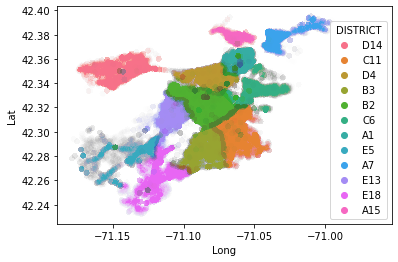

In [50]:
sns.scatterplot(x='Long', y = 'Lat', alpha=0.003, hue='DISTRICT', data=data)

In [51]:
import plotly.express as px

In [ ]:
# TODO 
# draw a nice map with district name on map
